<style>
body {
    max-width: 900px;
    margin: 40px auto;
    padding: 0 20px;
    font-family: "Georgia", serif;
    line-height: 1.6;
}
</style>

<div style="text-align: center; padding: 60px 60px">
  <h1 style="font-weight: bold; font-size: 3.1em">
    GA-UFLP-9
  </h1>
</div>

## **CONFIGURACIÓN DE LA NOTEBOOK**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
from cargar_datos import *
from ga_uflp import *

In [ ]:
sns.set(style="whitegrid")
sns.set_palette("tab10")

# Personalizacion global con matplotlib
plt.rcParams.update({
    'axes.titlesize': 20,        # Tamaño del titulo
    'axes.titleweight': 'bold',  # Negrita en el titulo
    'xtick.labelsize': 8,        # Tamaño de los xticks
    'ytick.labelsize': 8,         # Tamaño de los yticks
    'grid.color': 'gray',         # Color de las lineas del grid
    'grid.linestyle': '--',       # Estilo de linea (puede ser '-', '--', '-.', ':')
    'grid.linewidth': 0.5,        # Grosor del grid
    'axes.grid': True,            # Asegura que el grid esté activado
    'axes.grid.axis': 'both',     # Aplica el grid a ambos ejes
    'lines.linewidth': 1.2,       # Grosor de las lineas
    'figure.figsize': (12, 6),   # Tamaño de la figura
})

# **CARGAR DATOS**

In [ ]:
file_name = 'UFLP-9'

In [5]:
n_instalaciones, n_clientes, costos_fijos, costos_de_transporte = cargar_datos('datos/'+file_name+'.txt')

# **HIPERPARÁMETROS**

In [ ]:
num_ejecuciones = 9
resultados = {}
random_seed = 8

path = "resultados"
os.makedirs(os.path.join(path, file_name), exist_ok=True)

In [ ]:
configuraciones = [
    # Mejor solucion
    {
        "tamaño_de_poblacion": 321,
        "tasa_de_mutacion": 0.6,
        "tasa_de_crossover": 0.6,
        "tamaño_del_torneo": 16,
        "maximo_de_generaciones": 1000,
        "tipo_de_crossover": "un_punto"
    },
    # Solucion mas rapida
    {
        "tamaño_de_poblacion": 30,
        "tasa_de_mutacion": 0.1,
        "tasa_de_crossover": 0.8,
        "tamaño_del_torneo": 3,
        "maximo_de_generaciones": 1000,
        "tipo_de_crossover": "uniforme"
    }
]

# **EJECUCIÓN**

In [ ]:
print(f"Ejecutando GA para {file_name} con semilla aleatoria: {random_seed}\n")

for config in configuraciones:
    nombre_configuracion = f"TamPob_{config['tamaño_de_poblacion']}_TasaMut_{config['tasa_de_mutacion']}_TasaCruz_{config['tasa_de_crossover']}_TamTorneo_{config['tamaño_del_torneo']}_MaxGen_{config['maximo_de_generaciones']}_{config['tipo_de_crossover']}"
    print(f"--- Ejecutando configuracion: {nombre_configuracion} ---")
    resultados[nombre_configuracion] = []

    for ejecucion in range(num_ejecuciones):
        ga = UFLP_GA(n_instalaciones, n_clientes, costos_fijos, costos_de_transporte,
                     config["tamaño_de_poblacion"], config["tasa_de_mutacion"], config["tasa_de_crossover"],
                     config["tamaño_del_torneo"], config["maximo_de_generaciones"])
        if config["tipo_de_crossover"] == "uniforme":
            ga._operador_de_crossover = ga._crossover_uniforme
        elif config["tipo_de_crossover"] == "un_punto":
            ga._operador_de_crossover = ga._crossover_un_punto
        else:
            raise ValueError(f"Tipo de crossover desconocido: {config['tipo_de_crossover']}")

        mejor_solucion, mejor_fitness, historial_de_fitnesses, tiempo_de_ejecucion, num_generaciones = ga.run()
        resultados[nombre_configuracion].append({
            "mejor_solucion": mejor_solucion+1,
            "mejor_costo": mejor_fitness,
            "tiempo_de_ejecucion": tiempo_de_ejecucion,
            "num_generaciones": num_generaciones,
            "historial_de_fitnesses": historial_de_fitnesses,
            "costos_de_transporte": ga.costos_transporte
        })
        print(f"Ejecucion {ejecucion + 1}/{num_ejecuciones}: Mejor Costo = {mejor_fitness:.2f}, Tiempo = {tiempo_de_ejecucion:.2f}s, Generaciones = {num_generaciones}")
    print("\n")

Ejecutando GA para UFLP-1 con semilla aleatoria: 8

--- Ejecutando configuracion: TamPob_321_TasaMut_0.6_TasaCruz_0.6_TamTorneo_16_MaxGen_300_un_punto ---
Ejecucion 1/2: Mejor Costo = 23468.00, Tiempo = 2.47s, Generaciones = 300
Ejecucion 2/2: Mejor Costo = 23468.00, Tiempo = 2.65s, Generaciones = 300


--- Ejecutando configuracion: TamPob_30_TasaMut_0.1_TasaCruz_0.8_TamTorneo_3_MaxGen_600_uniforme ---
Ejecucion 1/2: Mejor Costo = 23468.00, Tiempo = 0.24s, Generaciones = 600
Ejecucion 2/2: Mejor Costo = 23468.00, Tiempo = 0.22s, Generaciones = 600




# **RESUMEN**

In [12]:
tablas_resumen = {}
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    costos = [res["mejor_costo"] for res in resultados_ejecuciones]
    tiempos = [res["tiempo_de_ejecucion"] for res in resultados_ejecuciones]
    mejor_costo = min(costos)
    peor_costo = max(costos)
    costo_promedio = np.mean(costos)
    desviacion_estandar_costo = np.std(costos)
    tiempo_promedio = np.mean(tiempos)
    desviacion_porcentual = (peor_costo - mejor_costo) / mejor_costo * 100 if mejor_costo != 0 else np.inf

    tablas_resumen[nombre_configuracion] = pd.DataFrame({
        "Métrica": ["Mejor Costo", "Peor Costo", "Costo Promedio", "Desviacion Estandar Costo", "Tiempo Promedio de Ejecucion (s)", "Desviacion Porcentual (%)"],
        "Valor": [f"{mejor_costo:.2f}", f"{peor_costo:.2f}", f"{costo_promedio:.2f}", f"{desviacion_estandar_costo:.2f}", f"{tiempo_promedio:.2f}", f"{desviacion_porcentual:.2f}"]
    })

    os.makedirs(os.path.join(path, file_name, nombre_configuracion), exist_ok=True)

In [13]:
print("\n--- Estadisticas de Resumen por Configuracion ---")
for nombre_configuracion, resumen_df in tablas_resumen.items():
    print(f"\nConfiguracion: {nombre_configuracion}")
    print(resumen_df.to_string(index=False))
    resumen_df.to_csv(os.path.join(path, file_name, nombre_configuracion, f"resumen.csv"), index=False)


--- Estadisticas de Resumen por Configuracion ---

Configuracion: TamPob_321_TasaMut_0.6_TasaCruz_0.6_TamTorneo_16_MaxGen_300_un_punto
                         Métrica    Valor
                     Mejor Costo 23468.00
                      Peor Costo 23468.00
                  Costo Promedio 23468.00
       Desviacion Estandar Costo     0.00
Tiempo Promedio de Ejecucion (s)     2.56
       Desviacion Porcentual (%)     0.00

Configuracion: TamPob_30_TasaMut_0.1_TasaCruz_0.8_TamTorneo_3_MaxGen_600_uniforme
                         Métrica    Valor
                     Mejor Costo 23468.00
                      Peor Costo 23468.00
                  Costo Promedio 23468.00
       Desviacion Estandar Costo     0.00
Tiempo Promedio de Ejecucion (s)     0.23
       Desviacion Porcentual (%)     0.00


# **GRÁFICAS**

In [ ]:
plt.figure(figsize=(12, 6))
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    for i, res in enumerate(resultados_ejecuciones):
        plt.plot(res["historial_de_fitnesses"], label=f"{nombre_configuracion} (Ejecucion {i+1})" if i == 0 else "", alpha=0.3)
    longitud_minima = min(len(res["historial_de_fitnesses"]) for res in resultados_ejecuciones)
    historiales_truncados = [res["historial_de_fitnesses"][:longitud_minima] for res in resultados_ejecuciones]
    historial_promedio_fitnesses = np.mean(historiales_truncados, axis=0)
    plt.plot(historial_promedio_fitnesses, label=f"Prom. {nombre_configuracion}", linewidth=2)
    plt.xlabel("Generacion")
    plt.ylabel("Mejor fitness")
    plt.title("Curva de Convergencia del Mejor Fitness")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.savefig(os.path.join(path, file_name, nombre_configuracion, f"curvas_convergencia.pdf"), bbox_inches='tight')
    plt.close()

In [ ]:
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    plt.figure(figsize=(4, 6))
    costos = [res["mejor_costo"] for res in resultados_ejecuciones]
    plt.boxplot(costos, positions=[list(resultados.keys()).index(nombre_configuracion)], patch_artist=True, widths=0.5)
    plt.xlabel("Configuracion")
    plt.ylabel("Mejor Costo")
    plt.title("Mejores Costos")
    plt.grid(True, axis='y')
    plt.savefig(os.path.join(path, file_name, nombre_configuracion, "boxplot_mejores_costos.pdf"), bbox_inches='tight')
    plt.close()

In [18]:
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    texto = ""
    mejor_ejecucion = min(resultados_ejecuciones, key=lambda x: x["mejor_costo"])
    texto += f"\nConfiguracion: {nombre_configuracion}\n"
    texto += f"  Mejor Solucion (Instalaciones Abiertas): {mejor_ejecucion['mejor_solucion']}\n"
    texto += f"  Mejor Costo: {mejor_ejecucion['mejor_costo']:.2f}\n"
    texto += f"\nSemilla aleatoria utilizada para reproducibilidad: {random_seed}\n"

    texto += f"\nTiempo de Ejecucion: {mejor_ejecucion['tiempo_de_ejecucion']:.2f} segundos\n"

    ruta_archivo = os.path.join(path, file_name, nombre_configuracion, "mejores_soluciones.txt")
    with open(ruta_archivo, "w") as f:
        f.write(texto)

    print("Texto guardado en", ruta_archivo)

Texto guardado en resultados_uflp_ga\UFLP-1\TamPob_321_TasaMut_0.6_TasaCruz_0.6_TamTorneo_16_MaxGen_300_un_punto\mejores_soluciones.txt
Texto guardado en resultados_uflp_ga\UFLP-1\TamPob_30_TasaMut_0.1_TasaCruz_0.8_TamTorneo_3_MaxGen_600_uniforme\mejores_soluciones.txt


# **COMPARACIÓN**

In [19]:
# obtener el nombre completo de las configuraciones
nombrecompleto = ""
for config in resultados.keys():
    nombrecompleto += config

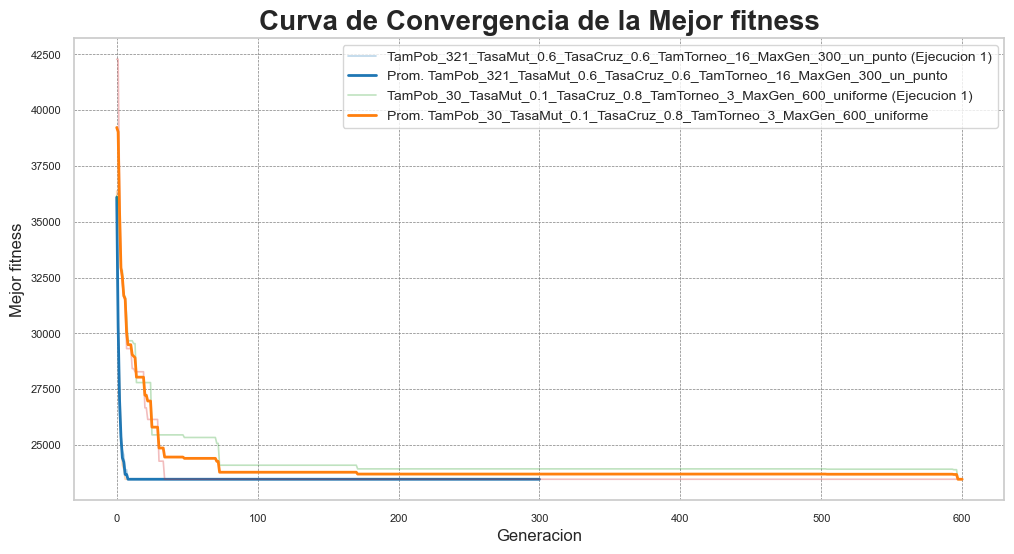

In [ ]:
plt.figure(figsize=(12, 6))
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    for i, res in enumerate(resultados_ejecuciones):
        plt.plot(res["historial_de_fitnesses"], label=f"{nombre_configuracion} (Ejecucion {i+1})" if i == 0 else "", alpha=0.3)
    longitud_minima = min(len(res["historial_de_fitnesses"]) for res in resultados_ejecuciones)
    historiales_truncados = [res["historial_de_fitnesses"][:longitud_minima] for res in resultados_ejecuciones]
    historial_promedio_fitnesses = np.mean(historiales_truncados, axis=0)
    plt.plot(historial_promedio_fitnesses, label=f"Prom. {nombre_configuracion}", linewidth=2, color=sns.color_palette("tab10")[list(resultados.keys()).index(nombre_configuracion)])
plt.xlabel("Generacion")
plt.ylabel("Mejor fitness")
plt.title("Curva de Convergencia del Mejor Fitness")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.show()
plt.close()

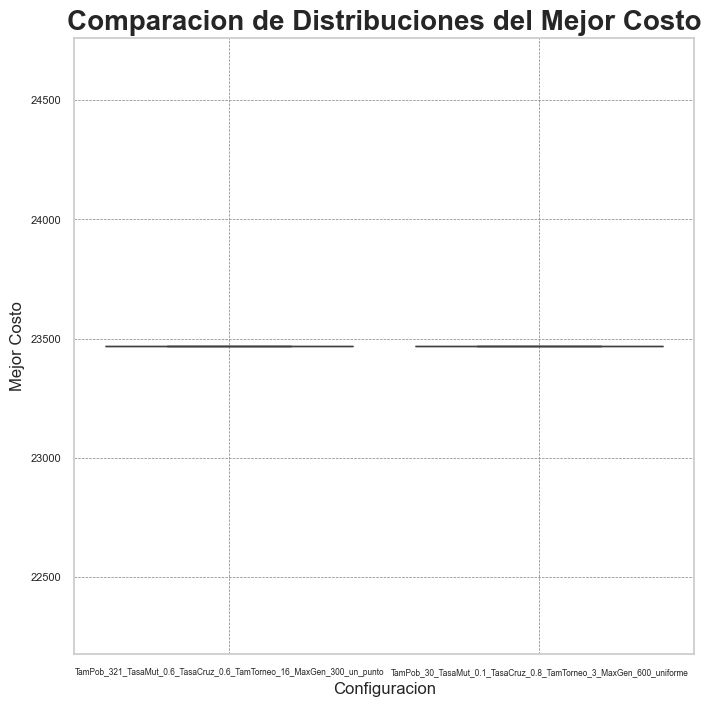

In [ ]:
datos_costos = {nombre_configuracion: [res["mejor_costo"] for res in resultados_ejecuciones] for nombre_configuracion, resultados_ejecuciones in resultados.items()}
plt.figure()
sns.boxplot(data=pd.DataFrame(datos_costos)).set(
    xlabel="Configuracion",
    ylabel="Mejor Costo",
    title="Comparacion de Distribuciones del Mejor Costo"
)
plt.xticks(fontsize=6)
plt.grid(True)
plt.show()
plt.close()